In [10]:
import numpy as np
import pandas as pd
import cv2  # OpenCV
import rasterio
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import ee  # Earth Engine API
import geemap
import os
import leaflet
import ipywidgets as widgets

In [11]:
#os.remove(os.path.expanduser('~/.config/earthengine/credentials'))
ee.Authenticate()
ee.Initialize(project='nikolavukasinovic')

# Definišite područje interesa (AOI)
aoi = ee.Geometry.Polygon([
    [
        [19.8296, 44.7666],  # Ugao 1 (Zapadna granica)
        [19.8396, 44.7666],  # Ugao 2 (Istočna granica)
        [19.8396, 44.7766],  # Ugao 3 (Severna granica)
        [19.8296, 44.7766]   # Ugao 4 (Južna granica)
    ]
])

# Učitajte Sentinel-2 snimke
dataset = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
            .filterDate('2022-01-01', '2022-12-31') \
            .filterBounds(aoi)
            
# Preuzmite slike
images = dataset.toList(dataset.size())

image = ee.Image(dataset.first())

vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB bands
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}


# Create a map for visualization
Map = geemap.Map()
Map.centerObject(aoi, 13)
Map.addLayer(image, vis_params, 'RGB Image')
Map.addLayer(aoi, {}, 'AOI')
Map.addLayerControl()
Map

Map(center=[44.77159996472699, 19.83459999998703], controls=(WidgetControl(options=['position', 'transparent_b…

In [12]:
def calculate_ndvi(image):
    # Calculate NDVI: (NIR - Red) / (NIR + Red)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Apply NDVI calculation to each image in the collection
dataset_with_ndvi = dataset.map(calculate_ndvi)

# Take the median NDVI image for the year
median_ndvi = dataset_with_ndvi.select('NDVI').median().clip(aoi)

# Set visualization parameters for NDVI
ndvi_params = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

# Visualize NDVI
Map = geemap.Map()
Map.centerObject(aoi, 13)
Map.addLayer(median_ndvi, ndvi_params, 'Median NDVI')
Map.addLayer(aoi, {}, 'AOI')
Map.addLayerControl()
Map

Map(center=[44.77159996472699, 19.83459999998703], controls=(WidgetControl(options=['position', 'transparent_b…

In [13]:
images_folder = os.path.join(os.getcwd(), 'images')
export_path = os.path.join(images_folder, 'median_ndvi.tif')

# Define the export task
geemap.ee_export_image(
    median_ndvi,
    filename=export_path,
    scale=5,
    region=aoi.getInfo()['coordinates']
)


Generating URL ...
Please wait ...
Data downloaded to k:\DetekcijaSuma\images\median_ndvi.tif


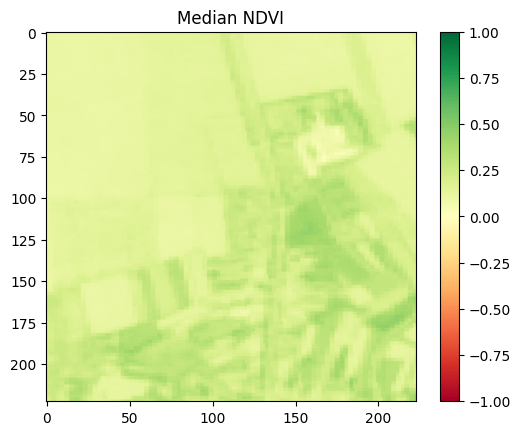

In [14]:
# Load the exported NDVI image
with rasterio.open(export_path) as src:
    ndvi_data = src.read(1)  # Read the first band
    profile = src.profile

# Display the NDVI image
plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Median NDVI')
plt.show()
